# Probando nuestro modelo

En este notebook vamos a ejemplificar el uso de nuestro modelo para extender fragmentos de notas MIDI.

En primer lugar importamos las librerías y módulos necesarios.

In [ ]:
import pandas as pd
import pretty_midi

from model import MelodIAModel, Utilities

Seleccionamos un archivo MIDI aleatorio del conjunto de prueba (test).

In [ ]:
df = pd.read_csv("data/maestro-v3.0.0/maestro-v3.0.0.csv")

In [3]:
df_test = df[df["split"] == "test"]

In [4]:
sample_file_path = Utilities.get_sample_midi_path(df_test)
sample_file_path

Ludwig van Beethoven - Sonata Op. 31, No. 3 in E-flat Major


'../maestro-v3.0.0/2004/MIDI-Unprocessed_XP_15_R1_2004_03_ORIG_MID--AUDIO_15_R1_2004_03_Track03_wav.midi'

Parseamos las notas del archivo MIDI y las almacenamos en un DataFrame.

In [5]:
sample_df = Utilities.midi_path_to_df(sample_file_path)
sample_df

,name,pitch,start,end,step,duration,velocity
0,C5,72,1.008333,1.187500,0.000000,0.179167,54
1,D#4,63,1.050000,1.215625,0.041667,0.165625,40
2,C4,60,1.052083,1.194792,0.002083,0.142708,42
3,D#3,51,1.067708,1.883333,0.015625,0.815625,29
4,G#3,56,1.068750,1.818750,0.001042,0.750000,26
...,...,...,...,...,...,...,...
10258,D#2,39,1118.635417,1118.728125,0.000000,0.092708,92
10259,D#5,75,1118.637500,1118.738542,0.002083,0.101042,103
10260,G5,79,1118.639583,1118.746875,0.002083,0.107292,87
10261,A#5,82,1118.671875,1118.756250,0.032292,0.084375,52


In [6]:
sample_df.dtypes

name         object
pitch         int64
start       float64
end         float64
step        float64
duration    float64
velocity      int64
dtype: object

In [7]:
sample_df.describe()

,pitch,start,end,step,duration,velocity
count,10263.000000,10263.000000,10263.000000,10263.000000,10263.000000,10263.000000
mean,60.922245,579.605596,579.773422,0.108903,0.167826,62.411478
std,12.286223,341.222840,341.221355,0.205549,0.255974,15.507341
min,29.000000,1.008333,1.187500,0.000000,0.001042,6.000000
25%,53.000000,271.280729,271.336458,0.009375,0.052083,52.000000
50%,60.000000,552.667708,552.698958,0.073958,0.079167,63.000000
75%,70.000000,915.891667,916.100000,0.125000,0.137500,73.000000
max,91.000000,1118.682292,1118.756250,5.416667,3.121875,106.000000


Creamos un objeto de PrettyMIDI.

In [8]:
pm = pretty_midi.PrettyMIDI(sample_file_path)

En la siguiente imagen podemos ver un "piano_roll" con todas las notas. Se puede apreciar como se distribuyen a través del tiempo y del pitch.

/home/carmenfdez/MUS/melodIA/model/model.py:147: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


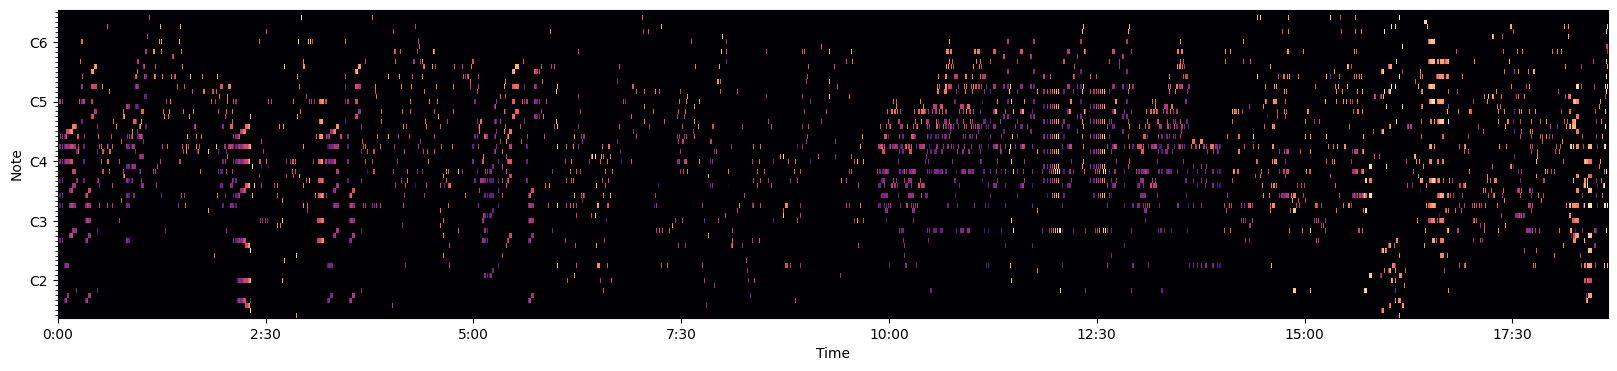

In [9]:
Utilities.plot_piano_roll(pm, 29, 91)

También podemos escucharlo.

In [ ]:
Utilities.display_audio(pm, seconds=30)

## Generación de notas con el modelo

Para poder generar nuevas notas con nuestro modelo necesitamos preprocesar el input que hayamos elegido de forma similar a cómo lo hicimos con los datos de entrenamiento. Para ello almacenamos las características de las notas (pitch, step, duration, velocity) en un array de NumPy que pueda ser procesado correctamente por el modelo (tensorflow). También normalizamos los valores de pitch y velocity al igual que hicimos antes de entrenar el modelo.

In [10]:
notes = Utilities.midi_to_numpy(pm)

# Vamos a usar las primeras 25 notas (una secuencia)
notes = MelodIAModel.normalize(notes[:25])
notes

array([[ 0.56692913,  0.        ,  0.17916667,  0.42063492],
       [ 0.47244094,  0.04375   ,  0.14270833,  0.32539683],
       [ 0.49606299, -0.00208333,  0.165625  ,  0.30952381],
       [ 0.51181102,  0.415625  ,  0.04479167,  0.4047619 ],
       [ 0.51181102,  0.13854167,  0.06145833,  0.4047619 ],
       [ 0.34645669, -0.52291667,  0.62395833,  0.26984127],
       [ 0.44094488, -0.0125    ,  0.75      ,  0.1984127 ],
       [ 0.41732283,  0.025     ,  0.7875    ,  0.20634921],
       [ 0.4015748 , -0.02604167,  0.815625  ,  0.22222222],
       [ 0.56692913,  1.58645833,  0.165625  ,  0.3968254 ],
       [ 0.47244094,  0.04479167,  0.14583333,  0.32539683],
       [ 0.49606299, -0.01666667,  0.16354167,  0.33333333],
       [ 0.51181102,  0.46041667,  0.03541667,  0.33333333],
       [ 0.44094488, -0.44375   ,  0.65      ,  0.27777778],
       [ 0.34645669, -0.00833333,  0.671875  ,  0.3015873 ],
       [ 0.41732283,  0.05208333,  0.665625  ,  0.27777778],
       [ 0.4015748 , -0.

Cargamos nuestro modelo.

In [11]:
model = MelodIAModel.load_model()

I0000 00:00:1747240053.719474  142788 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:02:00.0, compute capability: 8.6


Modelo cargado desde: melodIAmodel.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     68,096 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ velocity (Dense)    │ (None, 1)         │        129 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 254,987 (996.05 KB)

 Trainable params: 84,995 (332.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 169,992 (664.04 KB)

Ahora que tenemos nuestro input preprocesado y nuestro modelo, generamos una secuencia de 50 notas. Para ello utilizamos la función *predict_sequence* que realiza lo siguiente:
- Utiliza el input para que el modelo genere la nota inmediatamente siguiente.
- Elimina la primera nota del input (son 25 notas en total) y añade la nota generada como última nota.
- Vuelve a generar una nueva nota.
- Itera hasta generar el número de notas deseado.

In [12]:
generated_notes = MelodIAModel.predict_sequence(model, notes, num_predictions=50, temperature=1.0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


I0000 00:00:1747240055.428399  143077 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

Podemos ver las notas generadas por el modelo. Los valores de pitch y velocity están normalizados.

In [13]:
generated_notes.head(10)

,pitch,step,duration,velocity,start,end
0,0.456693,0.044780,0.272940,0.335434,0.044780,0.317720
1,0.511811,0.068291,0.289816,0.333304,0.113071,0.402887
2,0.433071,0.095180,0.295510,0.336693,0.208251,0.503762
3,0.488189,0.113931,0.293482,0.337989,0.322183,0.615664
4,0.480315,0.080965,0.307806,0.344046,0.403148,0.710954
5,0.393701,0.077198,0.332727,0.340882,0.480347,0.813074
6,0.511811,0.103402,0.333740,0.343357,0.583749,0.917489
7,0.488189,0.100916,0.339574,0.342337,0.684665,1.024239
8,0.425197,0.103126,0.346225,0.332283,0.787791,1.134016
9,0.472441,0.094609,0.360025,0.331841,0.882400,1.242425


Desnormalizamos pitch y velocity para poder convertir las notas generadas a MIDI

In [14]:
generated_notes = MelodIAModel.desnormalize(generated_notes)
generated_notes.head()

,pitch,step,duration,velocity,start,end
0,58,0.044780,0.272940,43,0.044780,0.317720
1,65,0.068291,0.289816,42,0.113071,0.402887
2,55,0.095180,0.295510,43,0.208251,0.503762
3,62,0.113931,0.293482,43,0.322183,0.615664
4,61,0.080965,0.307806,44,0.403148,0.710954


In [15]:
generated_notes.dtypes

pitch         int64
step        float64
duration    float64
velocity      int64
start       float64
end         float64
dtype: object

### Fragmento original usado como secuencia inicial

In [17]:
original_pm = Utilities.notes_to_midi(sample_df[:25])

In [18]:
Utilities.display_audio(original_pm)

/home/carmenfdez/MUS/melodIA/model/model.py:147: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


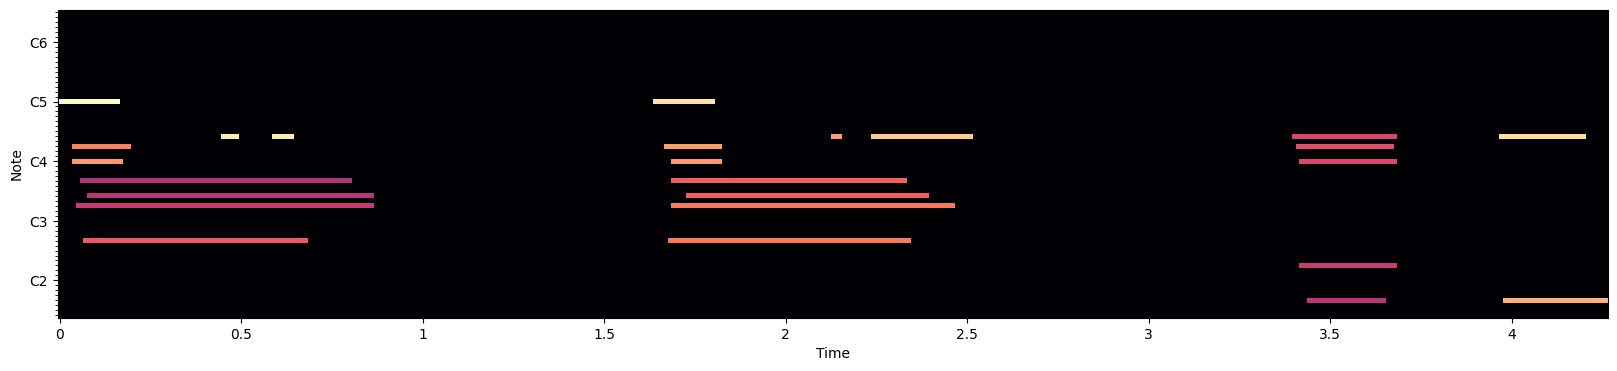

In [19]:
Utilities.plot_piano_roll(original_pm, 29, 91)

### Continuación del fragmento original

In [21]:
original_extended_pm = Utilities.notes_to_midi(sample_df[25:75])

In [22]:
Utilities.display_audio(original_extended_pm)

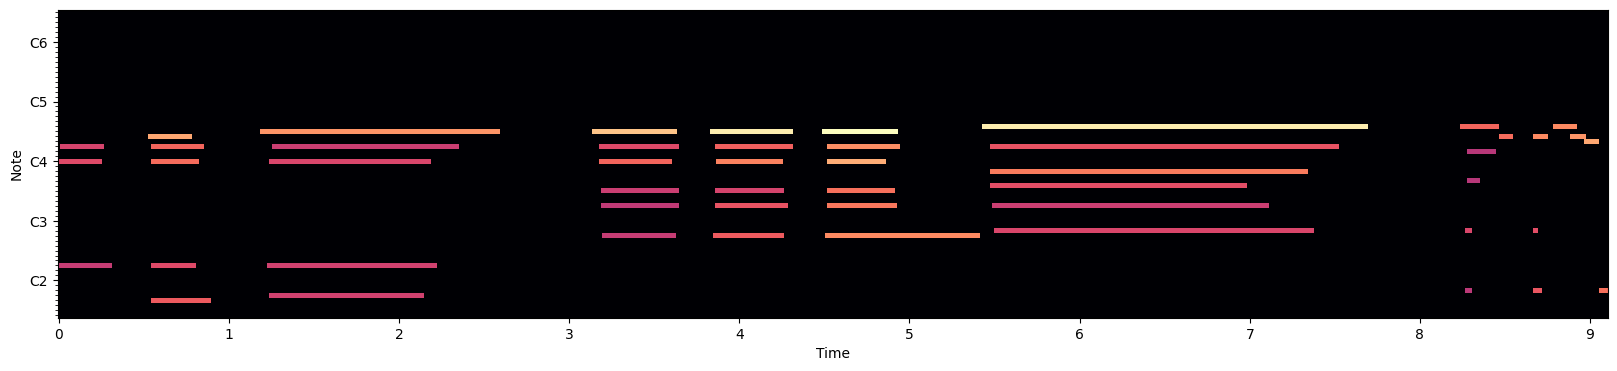

In [24]:
Utilities.plot_piano_roll(original_extended_pm, 29, 91)

### Continuación del fragmento hecha por el modelo

In [25]:
out_pm = Utilities.notes_to_midi(generated_notes)

In [26]:
Utilities.display_audio(out_pm)

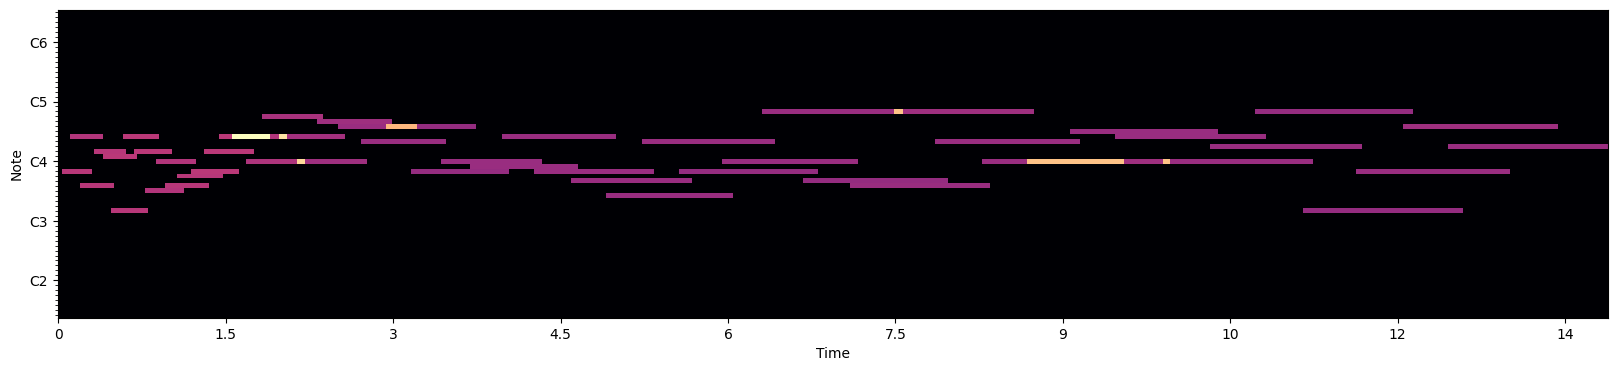

In [27]:
Utilities.plot_piano_roll(out_pm, 29, 91)